In [1]:
# -------------------------------------------------------------------
# -------------------------------------------------------------------
# ---------------------- Data Analysis Exercise  
# ---------------------- Senior Fraud Data Analyst (DA-IV) 
# ---------------------- Texas HHS – Office of Inspector General 
# -------------------------------------------------------------------
# -------------------------------------------------------------------

In [2]:
# -------------------------------------------------------------------
# -------------------------- REQUESTED ANALYSIS BY OIG INVESTIGATORS

In [3]:
# ------------- Importing required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Setting pd options
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None 

Matplotlib is building the font cache; this may take a moment.


In [4]:
# Reading in the cleaned data - 
claims_df = pd.read_excel('data/Medicaid_Fraud_Case_Cleaned.xlsx', sheet_name='Claims')
clients_df = pd.read_excel('data/Medicaid_Fraud_Case_Cleaned.xlsx', sheet_name='Clients')
providers_df = pd.read_excel('data/Medicaid_Fraud_Case_Cleaned.xlsx', sheet_name='Providers')
procedure_codes_df = pd.read_excel('data/Medicaid_Fraud_Case_Cleaned.xlsx', sheet_name='Procedure Codes')

In [5]:
# Checking shape -
print(claims_df.shape)
print(clients_df.shape)
print(providers_df.shape)
print(procedure_codes_df.shape)

(400, 9)
(150, 6)
(75, 5)
(7, 5)


In [6]:
# ------- Merging the data together for analysis - 

# Merging claims with providers
merged_df = pd.merge(left = claims_df
                    , right = providers_df
                    , how = 'left'
                    , left_on = 'Provider ID'
                    , right_on = 'Provider ID')

# Merging claims with clients
merged_df = pd.merge(left = merged_df
                    , right = clients_df
                    , how = 'left'
                    , left_on = 'Client ID'
                    , right_on = 'Client ID')

# Merging claims with procedures
merged_claims_df = pd.merge(left = merged_df
                        , right = procedure_codes_df
                        , how = 'left'
                        , left_on = 'Proc Code'
                        , right_on = 'Proc Code')

In [7]:
print(merged_claims_df.shape)

(400, 22)


In [8]:
merged_claims_df.columns

Index(['Claim ID', 'Provider ID', 'Client ID', 'Proc Code',
       'Claim Status Code', 'From Service Date', 'To Service Date',
       'Billed Amount ($)', 'Paid Amount ($)', 'Provider Name', 'Specialty',
       'Enrollment Date', 'Status', 'Client Name', 'Date of Birth', 'Gender',
       'Enrollment Start Date', 'Enrollment End Date', 'Description',
       'Typical Duration (hrs)', 'Category', 'Type of Service'],
      dtype='object')

### ---------------- FILTERING FOR THE REQUIRED CLAIMS

In [9]:
# ------------- Filtering on the conditions - 
# "From Service Date" >= 
# --- and
# "To Service Date" <=
# --- and
# "Claim Status Code" = 'Paid Claims'
# --- and 
# "Type of Service" = 'Medical'

required_claims_df = merged_claims_df[(merged_claims_df["From Service Date"] >= "2021-09-01") &
                                        (merged_claims_df["To Service Date"] <= "2022-08-31") &
                                        (merged_claims_df["Claim Status Code"] == "P") &
                                        (merged_claims_df["Type of Service"] == "Medical")]
required_claims_df.shape

(177, 22)

# ------------------------ DATA ANALYSIS FOR OIG INVESTIGATORS

# ----------- Sheet 2 - Provider Analysis : Payments

In [10]:
# Getting the Provider x Payment analysis
payment_analysis_df = required_claims_df.groupby(["Provider ID", "Provider Name"], as_index=False).agg({"Client ID": "count",
                                                                                                "Paid Amount ($)": "sum"})
# Renaming the columns - 
payment_analysis_df = payment_analysis_df.rename(columns={"Client ID": "Number of Claims Submitted"
                                        , "Paid Amount ($)": "Total Paid-Amount"})

# Calculating Avg amount paid per claim
payment_analysis_df["Average Paid-Amount per Claim"] = payment_analysis_df["Total Paid-Amount"] / payment_analysis_df["Number of Claims Submitted"] 

In [11]:
payment_analysis_df.shape

(60, 5)

In [12]:
payment_analysis_df.head()

,Provider ID,Provider Name,Number of Claims Submitted,Total Paid-Amount,Average Paid-Amount per Claim
0,P001,Prov_001,5,866.67,173.3340
1,P002,Prov_002,4,601.51,150.3775
2,P003,Prov_003,5,1438.59,287.7180
3,P004,Prov_004,2,378.35,189.1750
4,P005,Zoom Clinic,6,1362.90,227.1500


In [13]:
# ------------------------- DF ready for SHEET 2 : payment_analysis_df (will be saved at the end)

# ----------- Sheet 3 - Provider Analysis : Clients

In [14]:
# Getting the number of clients per provider
provider_client_df = required_claims_df.groupby(["Provider ID"], as_index=False).agg({"Client ID" : "nunique"})
# Renaming the columns - 
provider_client_df = provider_client_df.rename(columns={"Client ID": "Number of Clients"})

# Merging with main table - 
required_claims_df = pd.merge(left = required_claims_df
                             , right = provider_client_df
                             , how = "inner"
                             , left_on = "Provider ID"
                             , right_on = "Provider ID")

# Getting the required columns -
client_analysis_df = required_claims_df[['Provider ID', 'Provider Name', 'Specialty', 'Status'
                                        , "Number of Clients", 'Client ID', 'Client Name'
                                         , 'Date of Birth', 'Gender', 'Enrollment End Date']].drop_duplicates().reset_index(drop=True)

In [15]:
client_analysis_df.head()

,Provider ID,Provider Name,Specialty,Status,Number of Clients,Client ID,Client Name,Date of Birth,Gender,Enrollment End Date
0,P040,Prov_040,Home Health,Active,2,CL0002,Client_1,1950-06-22,Female,2026-03-06
1,P042,CarePlus Clinic,General Medicine,Inactive,3,CL0003,Client_2,1950-12-12,Female,2025-05-28
2,P027,Prov_027,Home Health,Inactive,4,CL0005,Client_4,1951-11-22,Male,2022-11-11
3,P024,Prov_024,Home Health,Active,3,CL0006,Client_5,1952-05-13,Other,2022-09-19
4,P032,Prov_032,Home Health,Active,4,CL0007,Client_124,1952-11-02,Male,2025-12-20


In [16]:
# ------------------------- DF ready for SHEET 3 : client_analysis_df (will be saved at the end)

# ----------- Sheet 4 - Outlier Analysis

### Outlier Analysis as per provider -

In [17]:
# Creating copy of the df -
payment_analysis_outlier_df = payment_analysis_df.copy()

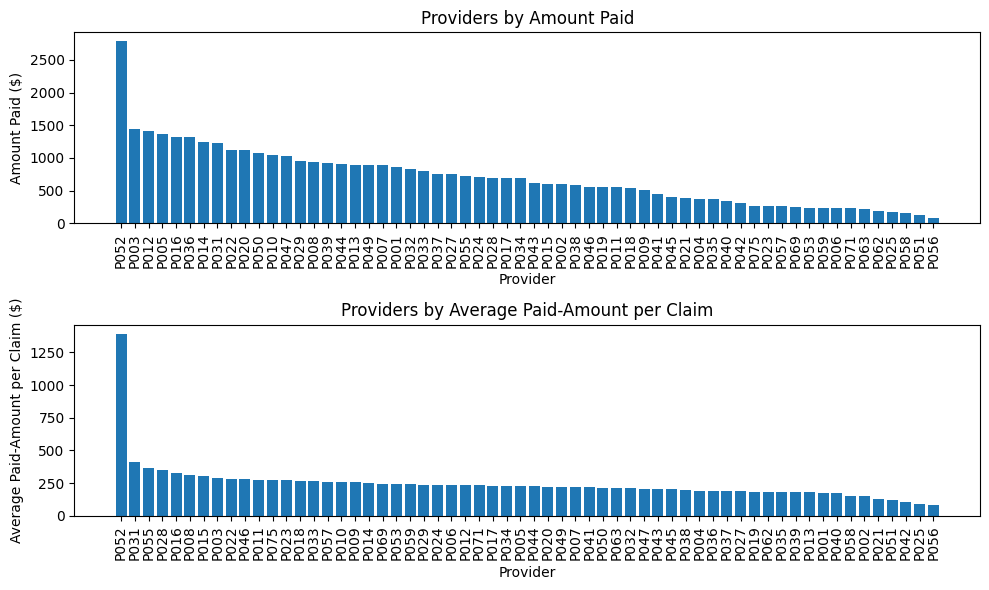

In [18]:
# ----------- Starting with the visual inspection on both columns

# Creating figure and subplots stacked vertically together for easy reading
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6))

# ---- Sorting by Paid amount
payment_analysis_outlier_df = payment_analysis_outlier_df.sort_values('Total Paid-Amount', ascending=False)

# Plotting Bar-plot 
ax1.bar(payment_analysis_outlier_df['Provider ID'], payment_analysis_outlier_df['Total Paid-Amount'])
ax1.set_title('Providers by Amount Paid')
ax1.set_xlabel('Provider')
ax1.set_ylabel('Amount Paid ($)')
ax1.tick_params(axis='x', rotation=90, labelright=False, labelleft=True)

# ---- Sorting by Paid amount
payment_analysis_outlier_df = payment_analysis_outlier_df.sort_values('Average Paid-Amount per Claim', ascending=False)

# Plotting Bar-plot 
ax2.bar(payment_analysis_outlier_df['Provider ID'], payment_analysis_outlier_df['Average Paid-Amount per Claim'])
ax2.set_title('Providers by Average Paid-Amount per Claim')
ax2.set_xlabel('Provider')
ax2.set_ylabel('Average Paid-Amount per Claim ($)')
ax2.tick_params(axis='x', rotation=90, labelright=False, labelleft=True)

plt.tight_layout()
plt.show()

In [19]:
# Provider P052 clearly stands out. In both average amount paid and total amount paid

C:\Users\Venu_Thota\AppData\Local\Temp\ipykernel_21140\1827166372.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([payment_analysis_outlier_df['Total Paid-Amount']


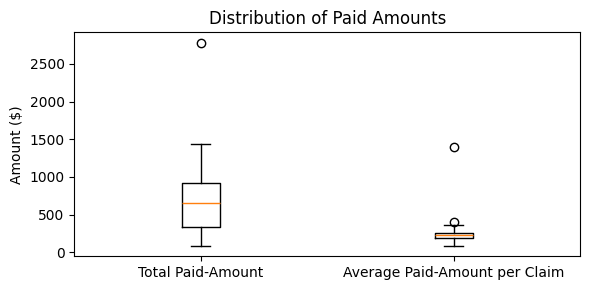

In [20]:
# ----------- Creating box plot of both Total amount and Average amount
fig, ax = plt.subplots(figsize=(6, 3))
ax.boxplot([payment_analysis_outlier_df['Total Paid-Amount']
            , payment_analysis_outlier_df['Average Paid-Amount per Claim']], labels=['Total Paid-Amount', 'Average Paid-Amount per Claim'])
ax.set_title('Distribution of Paid Amounts')
ax.set_ylabel('Amount ($)')
plt.tight_layout()
plt.show()

In [21]:
# ----------------------- Above we did visual analysis of how the providers were behaving.
#  --Let's use IQR to see if we have any more outliers present. IQR Method handles skewed data well, and isn’t affected by extreme values. It worked better than methods like Z-score, which assume a normal distribution—something medical claims data often doesn’t follow

# --------------- As per Total Paid Amount

# Generating Q1, Q3, IQR
Q1_total_paid_amount = payment_analysis_outlier_df['Total Paid-Amount'].quantile(0.25)
Q3_total_paid_amount = payment_analysis_outlier_df['Total Paid-Amount'].quantile(0.75)
IQR_total_paid_amount = Q3_total_paid_amount - Q1_total_paid_amount

# Generating respective lower and upper bound
lower_bound_total_paid_amount = Q1_total_paid_amount - 1.5 * IQR_total_paid_amount
upper_bound_total_paid_amount = Q3_total_paid_amount + 1.5 * IQR_total_paid_amount

# Creating the outlier flag - 
payment_analysis_outlier_df['Total Paid-Amount outlier flag'] = np.where((payment_analysis_outlier_df['Total Paid-Amount'] < lower_bound_total_paid_amount) 
                                                                          | (payment_analysis_outlier_df['Total Paid-Amount'] > upper_bound_total_paid_amount)
                                                                          , 1
                                                                          , 0)

# --------------- As per Average Amount per claim

# Generating Q1, Q3, IQR
Q1_average_paid_amount = payment_analysis_outlier_df['Average Paid-Amount per Claim'].quantile(0.25)
Q3_average_paid_amount = payment_analysis_outlier_df['Average Paid-Amount per Claim'].quantile(0.75)
IQR_average_paid_amount = Q3_average_paid_amount - Q1_average_paid_amount

# Generating respective lower and upper bound
lower_bound_average_paid_amount = Q1_average_paid_amount - 1.5 * IQR_average_paid_amount
upper_bound_average_paid_amount = Q3_average_paid_amount + 1.5 * IQR_average_paid_amount

# Creating the outlier flag - 
payment_analysis_outlier_df['Average Paid-Amount outlier flag'] = np.where((payment_analysis_outlier_df['Average Paid-Amount per Claim'] < lower_bound_average_paid_amount) 
                                                                          | (payment_analysis_outlier_df['Average Paid-Amount per Claim'] > upper_bound_average_paid_amount)
                                                                          , 1
                                                                          , 0)

In [22]:
# Checking the outlier flags - 
payment_analysis_outlier_df[payment_analysis_outlier_df['Total Paid-Amount outlier flag']==1]

,Provider ID,Provider Name,Number of Claims Submitted,Total Paid-Amount,Average Paid-Amount per Claim,Total Paid-Amount outlier flag,Average Paid-Amount outlier flag
48,P052,XYZ Health,2,2782.36,1391.18,1,1


In [23]:
payment_analysis_outlier_df[payment_analysis_outlier_df['Average Paid-Amount outlier flag']==1]

,Provider ID,Provider Name,Number of Claims Submitted,Total Paid-Amount,Average Paid-Amount per Claim,Total Paid-Amount outlier flag,Average Paid-Amount outlier flag
48,P052,XYZ Health,2,2782.36,1391.18,1,1
28,P031,Mesa Health,3,1227.72,409.24,0,1


In [24]:
# Combining both flags into 1 as Payment flag
payment_analysis_outlier_df['Payment Outlier Flag'] = payment_analysis_outlier_df[['Total Paid-Amount outlier flag','Average Paid-Amount outlier flag']].max(axis=1)
# Dropping the other 2 flags
payment_analysis_outlier_df = payment_analysis_outlier_df.drop(['Total Paid-Amount outlier flag','Average Paid-Amount outlier flag'], axis=1)

### Outlier Analysis as per clients -

In [25]:
# Creating copy of the df -
client_analysis_outlier_df = client_analysis_df[['Provider ID', 'Number of Clients']].drop_duplicates().reset_index(drop=True)

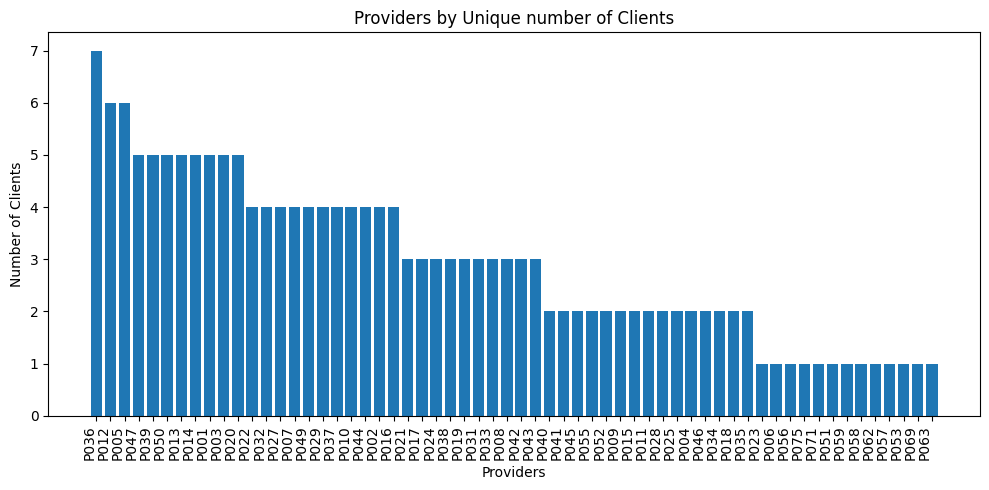

In [26]:
# ----------- Using similar approach, starting with visual inspection

# ---- Sorting by number of unique clients
client_analysis_outlier_df = client_analysis_outlier_df.sort_values('Number of Clients', ascending=False)

fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(client_analysis_outlier_df['Provider ID'], client_analysis_outlier_df['Number of Clients'])
ax.set_title('Providers by Unique number of Clients')
ax.set_xlabel('Providers')
ax.set_ylabel('Number of Clients')
plt.xticks(rotation=90, ha='right')
plt.tight_layout()
plt.show()

In [27]:
# visually, we can't seem to any one particular provider stand out except for the 1 with 7 unique clients.
# Let's see what the Box-plot shows us

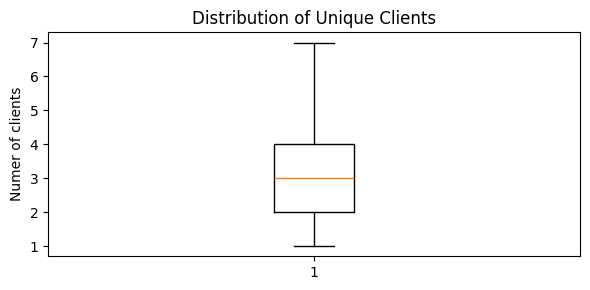

In [28]:
# ----------- Creating box plot of Unique number of clients
fig, ax = plt.subplots(figsize=(6, 3))
ax.boxplot(client_analysis_outlier_df['Number of Clients'])
ax.set_title('Distribution of Unique Clients')
ax.set_ylabel('Numer of clients')
plt.tight_layout()
plt.show()

In [29]:
# Again nothing stands out.
# Let's see if the we get something from IQR

In [30]:
# ----------------------- Above we did visual analysis of how the providers were behaving.
#                         Let's use IQR to see if we have any outliers present

# --------------- As per Number of clients

# Generating Q1, Q3, IQR
Q1_number_clients = client_analysis_outlier_df['Number of Clients'].quantile(0.25)
Q3_number_clients = client_analysis_outlier_df['Number of Clients'].quantile(0.75)
IQR_number_clients = Q3_number_clients - Q1_number_clients

# Generating respective lower and upper bound
lower_bound_number_clients = Q1_number_clients - 1.5 * IQR_number_clients
upper_bound_number_clients = Q3_number_clients + 1.5 * IQR_number_clients

# Creating the outlier flag - 
client_analysis_outlier_df['Number of Clients outlier flag'] = np.where((client_analysis_outlier_df['Number of Clients'] < lower_bound_number_clients) 
                                                                          | (client_analysis_outlier_df['Number of Clients'] > upper_bound_number_clients)
                                                                          , 1
                                                                          , 0)

In [31]:
client_analysis_outlier_df['Number of Clients outlier flag'].value_counts()

Number of Clients outlier flag
0    60
Name: count, dtype: int64

### Outlier Analysis as per gender -

In [32]:
# ---------------------- Checking the claims as per gender by each provider

# Creating grouped Df - 
# provider_gender_df = required_claims_df.groupby(["Provider ID", "Gender"], as_index=False).agg({"Paid Amount ($)" : "sum"})
provider_gender_df = required_claims_df.groupby(['Provider ID', 'Gender'])['Paid Amount ($)'].sum()
# Renaming the columns - 
# provider_gender_df = provider_gender_df.rename(columns={"Paid Amount ($)": "Total Paid-Amount"})

In [33]:
provider_gender_df.head()

Provider ID  Gender
P001         Female    428.79
             Male      100.90
             Other     336.98
P002         Female    333.77
             Other     267.74
Name: Paid Amount ($), dtype: float64

In [34]:
# Making column per gender
provider_gender_df = provider_gender_df.unstack(level='Gender', fill_value=0)
provider_gender_df = provider_gender_df.reset_index()

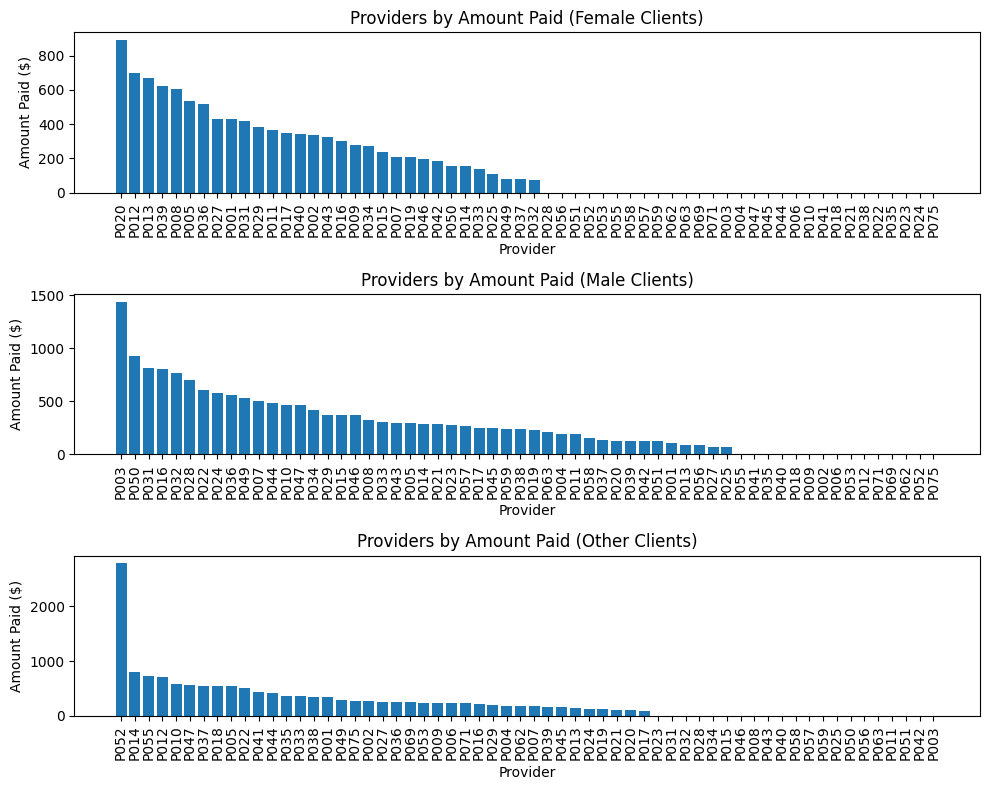

In [35]:
# ----------- Starting with the visual inspection on both columns

# Creating figure and subplots stacked vertically together for easy reading
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 8))

# ---- Sorting by Female Paid amount
provider_gender_df = provider_gender_df.sort_values('Female', ascending=False)

# Plotting Bar-plot 
ax1.bar(provider_gender_df['Provider ID'], provider_gender_df['Female'])
ax1.set_title('Providers by Amount Paid (Female Clients)')
ax1.set_xlabel('Provider')
ax1.set_ylabel('Amount Paid ($)')
ax1.tick_params(axis='x', rotation=90, labelright=False, labelleft=True)

# ---- Sorting by Male Paid amount
provider_gender_df = provider_gender_df.sort_values('Male', ascending=False)

# Plotting Bar-plot 
ax2.bar(provider_gender_df['Provider ID'], provider_gender_df['Male'])
ax2.set_title('Providers by Amount Paid (Male Clients)')
ax2.set_xlabel('Provider')
ax2.set_ylabel('Amount Paid ($)')
ax2.tick_params(axis='x', rotation=90, labelright=False, labelleft=True)

# ---- Sorting by Other Paid amount
provider_gender_df = provider_gender_df.sort_values('Other', ascending=False)

# Plotting Bar-plot 
ax3.bar(provider_gender_df['Provider ID'], provider_gender_df['Other'])
ax3.set_title('Providers by Amount Paid (Other Clients)')
ax3.set_xlabel('Provider')
ax3.set_ylabel('Amount Paid ($)')
ax3.tick_params(axis='x', rotation=90, labelright=False, labelleft=True)

plt.tight_layout()
plt.show()

In [36]:
provider_gender_df['Avoiding 1 gender flag'] = np.where(((provider_gender_df['Female'] == 0) & (provider_gender_df['Male'] == 0))
                                                        | ((provider_gender_df['Female'] == 0) & (provider_gender_df['Other'] == 0))
                                                        | ((provider_gender_df['Male'] == 0) & (provider_gender_df['Other'] == 0))
                                                        , 1
                                                        , 0)

In [37]:
provider_gender_df['Avoiding 1 gender flag'].value_counts()

Avoiding 1 gender flag
0    39
1    21
Name: count, dtype: int64

In [38]:
# Here we can see approx 33% of providers, don't cater to 1 gender at all. 
# Let's see how many of them have most claim amount - 
client_analysis_outlier_df = pd.merge(left = client_analysis_outlier_df
                             , right = provider_gender_df
                             , how = 'inner'
                             , left_on = 'Provider ID'
                             , right_on = 'Provider ID')

In [39]:
# Combvining this with Client Outlier flag
client_analysis_outlier_df['Client Outlier Flag'] = client_analysis_outlier_df[['Number of Clients outlier flag','Avoiding 1 gender flag']].max(axis=1)
client_analysis_outlier_df = client_analysis_outlier_df.drop(['Number of Clients outlier flag','Avoiding 1 gender flag'], axis=1)

In [40]:
client_analysis_outlier_df.head()

,Provider ID,Number of Clients,Female,Male,Other,Client Outlier Flag
0,P036,7,515.22,554.96,248.22,0
1,P012,6,696.54,0.00,712.92,0
2,P005,6,535.46,290.87,536.57,0
3,P047,5,0.00,462.44,571.42,0
4,P039,5,619.93,127.37,170.39,0


### Outlier Analysis as per claim dates -

In [41]:
# ---- Enrollment and claim date check
# Analyzing if any payments were made outside the 6-month 'grace' period

In [42]:
# First setting the 6 month offset 
six_months = pd.DateOffset(months=6)

# Filtering to see how many claims during our analysis period were out of this date range
required_claims_df['Enrollment_Claim_Date_Breach_Flag'] = np.where((required_claims_df["Enrollment End Date"] < required_claims_df["From Service Date"] - six_months) &
                                                                    (required_claims_df["Enrollment Start Date"] > required_claims_df["To Service Date"] + six_months)
                                                                  , 1
                                                                  , 0)

required_claims_df['Enrollment_Claim_Date_Breach_Flag'].value_counts()

Enrollment_Claim_Date_Breach_Flag
0    177
Name: count, dtype: int64

In [43]:
required_claims_df[required_claims_df['Enrollment_Claim_Date_Breach_Flag'] == 1].head()

,Claim ID,Provider ID,Client ID,Proc Code,Claim Status Code,From Service Date,To Service Date,Billed Amount ($),Paid Amount ($),Provider Name,Specialty,Enrollment Date,Status,Client Name,Date of Birth,Gender,Enrollment Start Date,Enrollment End Date,Description,Typical Duration (hrs),Category,Type of Service,Number of Clients,Enrollment_Claim_Date_Breach_Flag


In [44]:
# We see all claims were made within the specified period.

### Creating final Outlier Sheet -

In [45]:
# Combining both outliers table 
final_outlier_df = pd.merge(left = payment_analysis_outlier_df[['Provider ID', 'Provider Name', 'Number of Claims Submitted'
                                                                , 'Total Paid-Amount', 'Average Paid-Amount per Claim', 'Payment Outlier Flag']]
                           , right = client_analysis_outlier_df[['Provider ID', 'Number of Clients', 'Client Outlier Flag']]
                           , how = 'inner'
                           , left_on = 'Provider ID'
                           , right_on = 'Provider ID')

In [46]:
client_analysis_outlier_df.columns

Index(['Provider ID', 'Number of Clients', 'Female', 'Male', 'Other',
       'Client Outlier Flag'],
      dtype='object')

In [47]:
# ------------------------- DF ready for SHEET 4 : final_outlier_df (will be saved at the end)

# ----------- Sheet 1 - Summary

In [48]:
# Finally creating the summary analysis for the investigators
final_summary_df = pd.merge(left = required_claims_df[['Provider ID', 'Provider Name', 'Status', 'Client ID', 'Client Name', 'Date of Birth']]
                           , right = final_outlier_df[['Provider ID', 'Number of Clients', 'Number of Claims Submitted', 'Total Paid-Amount'
                                                       , 'Average Paid-Amount per Claim', 'Payment Outlier Flag', 'Client Outlier Flag']]
                           , how = 'left'
                           , left_on = 'Provider ID'
                           , right_on = 'Provider ID')

# Re-arranging columns
final_summary_df = final_summary_df[['Provider ID', 'Provider Name', 'Status', 'Number of Clients'
                                     , 'Client ID', 'Client Name', 'Date of Birth', 'Number of Claims Submitted'
                                     , 'Total Paid-Amount', 'Average Paid-Amount per Claim', 'Payment Outlier Flag'
                                     , 'Client Outlier Flag']]

# Sorting by Total Amount paid
final_summary_df = final_summary_df.sort_values('Total Paid-Amount', ascending=False).head(10)

In [49]:
# ------------------------- DF ready for SHEET 1 : final_summary_df (will be saved at the end)

# ----------- Saving Excel sheet

In [50]:
# Saving the above df in separate excel sheet as requested -
with pd.ExcelWriter("data/Medicaid_Fraud_Case_OIG_Investigated_Data.xlsx", engine="xlsxwriter") as writer:
    final_summary_df.to_excel(writer, sheet_name="Summary", index=False)
    payment_analysis_df.to_excel(writer, sheet_name="Payments Analysis", index=False)
    client_analysis_df.to_excel(writer, sheet_name="Client Analysis", index=False)
    final_outlier_df.to_excel(writer, sheet_name="Outlier Analysis", index=False)